In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2


path = 'Pet_train/'

print(os.listdir(path))


2024-04-19 17:36:22.289824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['cat.6.jpg', 'cat.198.jpg', 'dog.167.jpg', 'dog.173.jpg', 'dog.36.jpg', 'dog.22.jpg', 'cat.30.jpg', 'cat.24.jpg', 'cat.167.jpg', 'dog.198.jpg', 'cat.18.jpg', 'cat.173.jpg', 'cat.172.jpg', 'cat.19.jpg', 'cat.166.jpg', 'dog.199.jpg', 'cat.25.jpg', 'cat.31.jpg', 'dog.23.jpg', 'dog.37.jpg', 'dog.172.jpg', 'cat.199.jpg', 'dog.166.jpg', 'cat.7.jpg', 'cat.5.jpg', 'dog.170.jpg', 'dog.164.jpg', 'dog.21.jpg', 'dog.158.jpg', 'dog.35.jpg', 'cat.27.jpg', 'cat.33.jpg', 'cat.158.jpg', 'cat.170.jpg', 'cat.164.jpg', 'cat.165.jpg', 'cat.171.jpg', 'cat.159.jpg', 'cat.32.jpg', 'cat.26.jpg', 'dog.159.jpg', 'dog.34.jpg', 'dog.20.jpg', 'dog.165.jpg', 'dog.171.jpg', 'cat.4.jpg', 'cat.0.jpg', 'dog.149.jpg', 'dog.24.jpg', 'dog.30.jpg', 'dog.175.jpg', 'dog.18.jpg', 'dog.161.jpg', 'cat.175.jpg', 'cat.161.jpg', 'cat.22.jpg', 'cat.149.jpg', 'cat.36.jpg', 'cat.37.jpg', 'cat.148.jpg', 'cat.23.jpg', 'cat.160.jpg', 'cat.174.jpg', 'dog.160.jpg', 'dog.174.jpg', 'dog.19.jpg', 'dog.31.jpg', 'dog.148.jpg', 'dog.25.jpg', 'c

In [2]:
image_size=224
batch_size=128
channels=3
epochs=100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    seed=123,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 0 files belonging to 0 classes.


ValueError: No images found in directory Pet_train/. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [45]:
class_names=dataset.class_names
class_names

['cat', 'dog']

In [46]:
import warnings
warnings.filterwarnings("ignore")
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(128, 224, 224, 3)
[0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0
 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0]


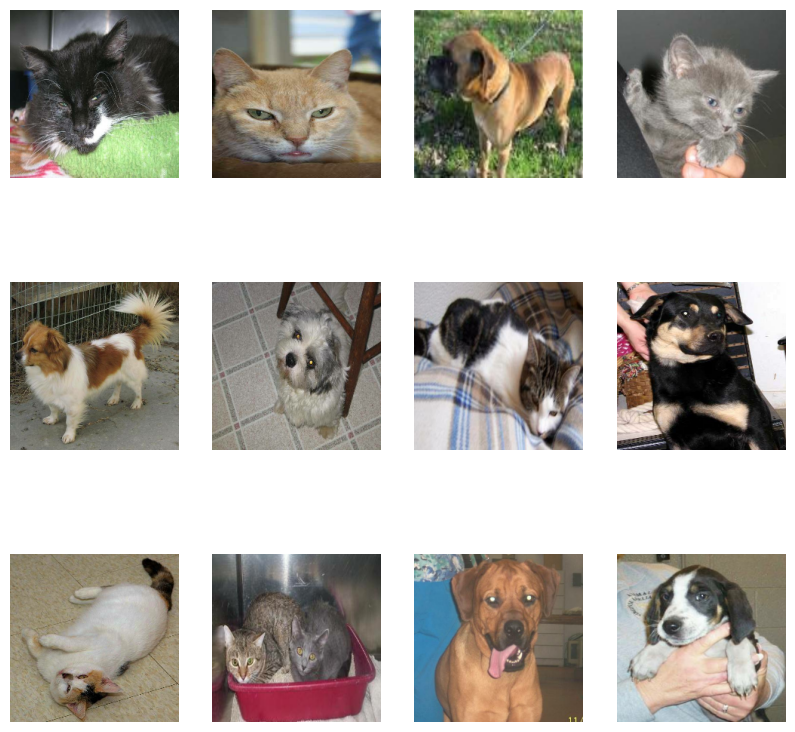

In [47]:
plt.figure(figsize=(10, 10))
for images_batch, label_batch in dataset.take(3):
    for i in range(12):
        ax=plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off')

In [48]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [49]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds)

3

In [50]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(image_size, image_size),
    tf.keras.layers.Rescaling(1./255)
])

In [52]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(image_size, image_size,3)),
    tf.keras.layers.RandomRotation(0.2),
])

In [53]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential

In [54]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 8
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(n_classes)
])
model.build(input_shape=input_shape)

In [55]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (128, 224, 224, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (128, 224, 224, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (128, 224, 224, 16)         │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (128, 112, 112, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (128, 112, 112, 16)         │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (128, 56, 56, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (128, 56, 56, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (128, 28, 28, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (128, 25088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (128, 32)                   │         802,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (128, 32)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (128, 32)                   │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (128, 32)                   │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (128, 32)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (128, 32)                   │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (128, 8)                    │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 811,832 (3.10 MB)

 Trainable params: 811,704 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

In [56]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [57]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=test_ds,
    verbose=1,
    epochs=epochs,
);

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1047 - loss: 2.6273 - val_accuracy: 0.0000e+00 - val_loss: 2.1298
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1100 - loss: 2.6081 - val_accuracy: 0.0000e+00 - val_loss: 2.3448
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 839ms/step - accuracy: 0.1194 - loss: 2.4798 - val_accuracy: 0.0547 - val_loss: 2.3162
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 749ms/step - accuracy: 0.1350 - loss: 2.4633 - val_accuracy: 0.2734 - val_loss: 2.2825
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1224 - loss: 2.3958 - val_accuracy: 0.4219 - val_loss: 2.2096
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 612ms/step - accuracy: 0.1370 - loss: 2.5582 - val_accuracy: 0.4766 - val_loss: 2.1337
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 633ms/step - accuracy: 0.1341 - loss: 2.4332 - val_accuracy: 0.5000 - val_loss: 2.0774
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1818 - loss: 2.4701 - val_accuracy: 0.5000 - val_

In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    

    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


ValueError: num must be an integer with 1 <= num <= 9, not 10

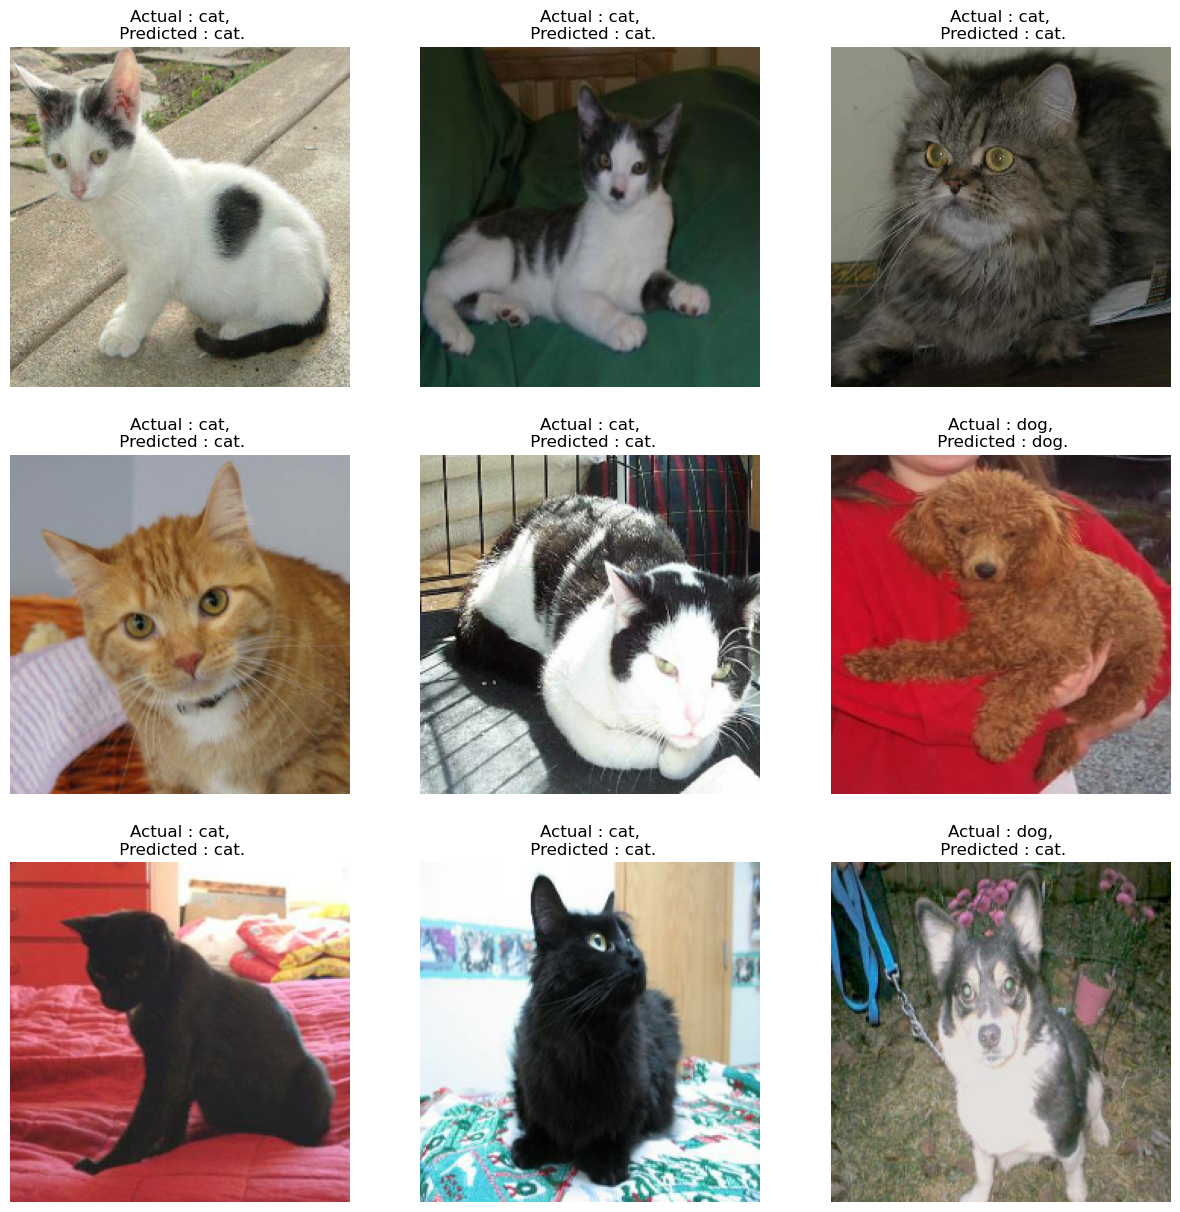

In [59]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(20):
        ax=plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class}.")
        plt.axis("off")